# Une représentation des inégalités scolaires


Ce projet a pour but d'étudier les inégalités scolaires à partir des résultats du baccalauréat et le revenu médian des communes.
Pour ce faire, nous avons récupéré des données de l'Education nationale sur les taux de réussite aux baccalauréats général, techonologique et professionnel. Par ailleurs, nous utilisons la base de données "Structure et distribution des revenus, inégalité des niveaux de vie en 2019" de l'INSEE. Nous aurons également recourt à l'annuaire de l'Education nationale pour avoir les coordonnées géographiques des lycées.

Le projet est structuré en trois grandes parties.
La première partie concerne la récupération de toutes les bases de données, leur adaptation à notre projet et leur jointure.
La deuxième partie est dédiée à la visualisation afin de pouvoir d'avoir une première idée de la dynamique des données. Elle regroupe des statistiques descriptives et des cartes interactives.
Dans la troisième partie, nous testons nos hypothèses sur les inégalités scolaires grâce à la modélisation. 







## Préliminaire - Installation des packages nécessaires 

In [1]:
!pip install pathlib2
!pip install python-Levenshtein
!pip install --upgrade xlrd
!pip install git+https://github.com/InseeFrLab/Py-Insee-Data.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.8 MB/s eta 0:00:00
  Cloning https://github.com/InseeFrLab/Py-Insee-Data.git to /tmp/pip-req-build-w9u9aq5x
  Running command git clone --filter=blob:none --quiet https://github.com/InseeFrLab/Py-Insee-Data.git /tmp/pip-req-build-w9u9aq5x
  Resolved https://github.com/InseeFrLab/Py-Insee-Data.git to commit 916d8bc82ea43f637047ed989fb7dbc491f56895
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 9.9 MB/s eta 0:00:00
  Created wheel for pynsee: filename=pynsee-0.1.2-py3-none-any.whl size=9805198 sha256=dfc21696873ae6b5ed4cfa438f40b82618c0ddc2f5f97710b633948476ab697d
  Stored in directory: /tmp/pip-ephem-wheel-cache-2me

In [2]:
import requests
url = 'https://github.com/InseeFrLab/Py-Insee-Data/archive/refs/heads/master.zip'
r = requests.get(url)
with open("pynsee.zip" , 'wb') as zipfile:
    zipfile.write(r.content)


In [3]:
!pip install --ignore-installed pynsee.zip
!pip install python-Levenshtein
!pip install openpyxl


Processing ./pynsee.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 6.8 MB/s eta 0:00:00
  Using cached Unidecode-1.3.6-py3-none-any.whl (235 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 10.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 25.0 MB/s eta 0:00:00
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached pathlib-1.0.1-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 5.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 9.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 9.0 MB/s

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynsee.download
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## I - Ouverture et manipulation des bases de données

### A - La base de données sur les résultats au baccaulauréat par lycée

Cette base de données, disponible sous format excel, réalisée par l'Education nationale, regroupe de nombreuses informations permettant de quantifier la réussite des lycéens : le taux de réussite au baccalauréat, le taux de mention, la valeur ajoutée des lycées par rapport aux résultats attendus, le taux de passage en première... Elle est composée de 2 fichiers distincts : l'un pour les filières générales et technologiques et l'un pour les filières professionnelles. Nous allons donc traiter ces 2 fichiers séparément, en gardant uniquement les colonnes qui nous intéressent avant de les joindre.

Nous commençons par ouvrir la feuille contenant les données pour les lycées généraux et technologiques. 
Nous supprimons les colonnes qui ne nous seront pas utiles (sur les taux attendus et les effectifs) afin de garder uniquement les taux de réussite et de mentions.

In [6]:
#file_name = "ival-2021---complet-xlsx-112652.xlsx"
df = pd.read_excel ("ival-2021---complet-xlsx-112652.xlsx", header = [0,1])

fichier_LGT = df.copy()
fichier_LGT = fichier_LGT.drop (["Valeur ajoutée du taux d'accès", "Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus", "Taux de mentions bruts", "Valeur ajoutée de taux de mentions"], axis = 1)

/tmp/ipykernel_123/339728722.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  fichier_LGT = fichier_LGT.drop (["Valeur ajoutée du taux d'accès"], axis = 1)
/tmp/ipykernel_123/339728722.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  fichier_LGT = fichier_LGT.drop(["Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus", "Taux de mentions bruts", "Valeur ajoutée de taux de mentions"], axis = 1)


Les données concernant les bacs technologiques étant divisées par filière, nous avons besoin de regrouper toutes les filières sous une seule colonne technologique. 

Nous commençons par calculer le nombre d'élèves présents au total au baccalauréat technologique. Pour cela, nous devons remplacer les valeurs non existantes par des zéros avant de faire le calcul.

In [7]:
fichier_LGT = fichier_LGT.fillna(0)
#fichier.loc[:,("Nombre d'élèves présents au Bac","Somme Pro")] = fichier["Nombre d'élèves présents au Bac", "STMG"] + fichier["Nombre d'élèves présents au Bac", "STI2D"] + fichier["Nombre d'élèves présents au Bac", "STD2A"]+fichier["Nombre d'élèves présents au Bac", "STL"]+df_rose["Nombre d'élèves présents au Bac", "ST2S"]+fichier["Nombre d'élèves présents au Bac", "S2TMD"]+fichier["Nombre d'élèves présents au Bac", "STHR"]#
fichier_LGT.loc[:,("Nombre d'élèves présents au Bac","Somme Techno")] = fichier_LGT["Nombre d'élèves présents au Bac", 'TOTAL']- fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"]
fichier_LGT["Nombre d'élèves présents au Bac"]


,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL,Somme Techno
0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54,0.0
1,122.0,28.0,0.0,0.0,0.0,50.0,0.0,0.0,200,78.0
2,98.0,0.0,41.0,0.0,26.0,0.0,0.0,0.0,165,67.0
3,174.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,234,60.0
4,160.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,214,54.0
...,...,...,...,...,...,...,...,...,...,...
2311,246.0,105.0,0.0,0.0,47.0,56.0,0.0,0.0,454,208.0
2312,244.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,360,116.0
2313,325.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,325,0.0
2314,221.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,251,30.0


Ensuite, nous calculons les totaux des taux de réussite bruts pour les filières technologiques. 

__!! faire des commentaires sur la technique utilisée__

In [8]:
#test = ((fichier_LGT["Taux de réussite bruts", "TOTAL"]*fichier_LGT["Nombre d'élèves présents au Bac", "TOTAL"])-(fichier_LGT["Taux de réussite bruts", "GNLE"]*fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"]))/fichier_LGT["Nombre d'élèves présents au Bac", "Somme Techno"]
#fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Taux de réussite bruts", "Taux brut techno")] = (fichier_LGT["Taux de réussite bruts", "TOTAL"]*fichier_LGT["Nombre d'élèves présents au Bac", "TOTAL"] - fichier_LGT["Taux de réussite bruts", "GNLE"]*fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"])/fichier_LGT["Nombre d'élèves présents au Bac", "Somme Techno"]#
stmg = fichier_LGT["Taux de réussite bruts", "STMG"]*fichier_LGT["Nombre d'élèves présents au Bac", "STMG"]
sti2d = fichier_LGT["Taux de réussite bruts", "STI2D"]*fichier_LGT["Nombre d'élèves présents au Bac", "STI2D"]
std2a = fichier_LGT["Taux de réussite bruts", "STD2A"]*fichier_LGT["Nombre d'élèves présents au Bac", "STD2A"]
stl = fichier_LGT["Taux de réussite bruts", "STL"]*fichier_LGT["Nombre d'élèves présents au Bac", "STL"]
st2s = fichier_LGT["Taux de réussite bruts", "ST2S"]*fichier_LGT["Nombre d'élèves présents au Bac", "ST2S"]
s2tmd = fichier_LGT["Taux de réussite bruts", "S2TMD"]*fichier_LGT["Nombre d'élèves présents au Bac", "S2TMD"]
sthr = fichier_LGT["Taux de réussite bruts", "STHR"]*fichier_LGT["Nombre d'élèves présents au Bac", "STHR"]
taux_tech_brut = (stmg + sti2d + std2a + stl + st2s + s2tmd + sthr)/fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"]


fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Taux de réussite bruts", "Taux brut techno")] = taux_tech_brut #>0.5 pour éviter erreurs d'arrondi de flottants#
fichier_LGT["Taux de réussite bruts"]
#pb avec test à cause des arrondis dans TOTAL (int pas float), résolu avec taux_techno #
#on ne peut pas le faire avec les taux de réussite attendus car on les a enlevé #
#on ne peut pas le faire avec la valeur ajoutée car mauvais type d’objet (on peut en tout cas le faire si besoin à partir du taux attendu et brut si on remet le taux attendu#


,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL,Taux brut techno
0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98,NaN
1,99.0,96.0,0.0,0.0,0.0,92.0,0.0,0.0,97,93.435897
2,100.0,0.0,100.0,0.0,96.0,0.0,0.0,0.0,99,98.447761
3,97.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,96,93.000000
4,99.0,0.0,96.0,0.0,0.0,0.0,0.0,0.0,99,96.000000
...,...,...,...,...,...,...,...,...,...,...
2311,99.0,99.0,0.0,0.0,96.0,91.0,0.0,0.0,98,96.168269
2312,100.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,100,99.000000
2313,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100,NaN
2314,99.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,99,100.000000


Nous calculons ces mêmes totaux pour les valeurs ajoutées. La difficulté réside dans le format des données dans les colonnes valeur ajoutée.

__!! Pareil expliquer les calculs__

In [9]:
#Il faut remplacer les taux non définis par des NaN et transformer en flottant#
liste= ["GNLE", "STMG", "STI2D", "STD2A", "STL", "ST2S", "S2TMD", "STHR", "TOTAL"]
for i in liste:
    fichier_LGT.loc[fichier_LGT["Valeur ajoutée du taux de réussite", i] == "ND", ("Valeur ajoutée du taux de réussite", i)] = np.NaN
    fichier_LGT["Valeur ajoutée du taux de réussite", i] = pd.to_numeric(fichier_LGT["Valeur ajoutée du taux de réussite", i])
fichier_LGT["Valeur ajoutée du taux de réussite"].info()
fichier_LGT["Valeur ajoutée du taux de réussite"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2316 entries, 0 to 2315
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GNLE    2301 non-null   float64
 1   STMG    2295 non-null   float64
 2   STI2D   2309 non-null   float64
 3   STD2A   2314 non-null   float64
 4   STL     2294 non-null   float64
 5   ST2S    2308 non-null   float64
 6   S2TMD   2311 non-null   float64
 7   STHR    2312 non-null   float64
 8   TOTAL   2301 non-null   float64
dtypes: float64(9)
memory usage: 163.0 KB


,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,2.0,5.0,0.0,0.0,0.0,-5.0,0.0,0.0,1.0
2,1.0,0.0,2.0,0.0,-1.0,0.0,0.0,0.0,1.0
3,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2311,0.0,1.0,0.0,0.0,-1.0,-5.0,0.0,0.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2314,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0


In [10]:
#calcul de la valeur ajoutée du taux de réussite pour les bacs techno, reprend tout pour éviter les problèmes d'arrondis#
stmg = fichier_LGT["Valeur ajoutée du taux de réussite", "STMG"]*fichier_LGT["Nombre d'élèves présents au Bac", "STMG"]
sti2d = fichier_LGT["Valeur ajoutée du taux de réussite", "STI2D"]*fichier_LGT["Nombre d'élèves présents au Bac", "STI2D"]
std2a = fichier_LGT["Valeur ajoutée du taux de réussite", "STD2A"]*fichier_LGT["Nombre d'élèves présents au Bac", "STD2A"]
stl = fichier_LGT["Valeur ajoutée du taux de réussite", "STL"]*fichier_LGT["Nombre d'élèves présents au Bac", "STL"]
st2s = fichier_LGT["Valeur ajoutée du taux de réussite", "ST2S"]*fichier_LGT["Nombre d'élèves présents au Bac", "ST2S"]
s2tmd = fichier_LGT["Valeur ajoutée du taux de réussite", "S2TMD"]*fichier_LGT["Nombre d'élèves présents au Bac", "S2TMD"]
sthr = fichier_LGT["Valeur ajoutée du taux de réussite", "STHR"]*fichier_LGT["Nombre d'élèves présents au Bac", "STHR"]
val_aj_tech = (stmg + sti2d + std2a + stl + st2s + s2tmd + sthr)/fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"]


fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Valeur ajoutée du taux de réussite", "Valeur ajoutée techno")] = val_aj_tech #>0.5 pour éviter les problèmes d'arrondis de flottants#
fichier_LGT["Valeur ajoutée du taux de réussite"]

,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL,Valeur ajoutée techno
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN
1,2.0,5.0,0.0,0.0,0.0,-5.0,0.0,0.0,1.0,-1.410256
2,1.0,0.0,2.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.835821
3,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-2.000000
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.000000
...,...,...,...,...,...,...,...,...,...,...
2311,0.0,1.0,0.0,0.0,-1.0,-5.0,0.0,0.0,0.0,-1.067308
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2314,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,2.000000


__On ré-indexe également la base des lycées généraux__

et technologiques pour faciliter les manipulations suivantes : nous allons effacer les informations relatives à des filières technologiques spécifiques étant donné qu'on s'intéresse seulement aux bacs technologiques en général.

In [11]:
fichier_LGT.columns = fichier_LGT.columns.map('_'.join).str.strip('_')
fichier_LGT = fichier_LGT.drop(["Nombre d'élèves présents au Bac_STMG","Nombre d'élèves présents au Bac_STI2D", "Nombre d'élèves présents au Bac_STD2A", "Nombre d'élèves présents au Bac_STL", "Nombre d'élèves présents au Bac_ST2S","Nombre d'élèves présents au Bac_S2TMD", "Nombre d'élèves présents au Bac_STHR", "Taux de réussite bruts_STMG",
"Taux de réussite bruts_STI2D","Taux de réussite bruts_STD2A","Taux de réussite bruts_STL","Taux de réussite bruts_ST2S","Taux de réussite bruts_S2TMD","Taux de réussite bruts_STHR", "Valeur ajoutée du taux de réussite_STMG","Valeur ajoutée du taux de réussite_STI2D","Valeur ajoutée du taux de réussite_STD2A", "Valeur ajoutée du taux de réussite_STL", "Valeur ajoutée du taux de réussite_ST2S", "Valeur ajoutée du taux de réussite_S2TMD", "Valeur ajoutée du taux de réussite_STHR"], axis=1)

Nous passons ensuite à la feuille concernant les lycées professionnels. 

Commme pour l'autre feuille, nous supprimons les colonnes qui ne nous sont pas utiles. Puis, nous devons renommer certaines colonnes afin qu'elles aient un nom distinctif quand nous joindrons cette feuille avec les données sur les filières générales et technologiques. 

In [12]:
df2 = pd.read_excel ("ival-2021---complet-xlsx-112652.xlsx", sheet_name = 1, header = [0,1])

fichier_LP = df2.copy()
fichier_LP = fichier_LP.drop (["Valeur ajoutée du taux d'accès", "Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus"], axis = 1)
fichier_LP.columns = fichier_LP.columns.map('_'.join).str.strip('_')
col_cons = ['Informations établissement_Académie', 'Informations établissement_Département', 'Informations établissement_Etablissement', 'Informations établissement_Ville', 'Informations établissement_UAI', 'Informations établissement_Code commune', 'Informations établissement_Secteur', "Nombre d'élèves présents au Bac_TOTAL", 'Taux de réussite bruts_TOTAL', 'Valeur ajoutée du taux de réussite_TOTAL']
fichier_LP = fichier_LP[col_cons]
fichier_LP = fichier_LP.rename(columns={"Nombre d'élèves présents au Bac_TOTAL": "Nombre d'élèves présents au Bac_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Taux de réussite bruts_TOTAL" : "Taux de réussite bruts_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Taux de mentions bruts_TOTAL" : "Taux de mentions bruts_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Valeur ajoutée du taux de réussite_TOTAL" : "Valeur ajoutée du taux de réussite_TOTAL_Pro"})
fichier_LP

/tmp/ipykernel_123/958335156.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  fichier_LP = fichier_LP.drop (["Valeur ajoutée du taux d'accès", "Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus"], axis = 1)


,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Informations établissement_UAI,Informations établissement_Code commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Valeur ajoutée du taux de réussite_TOTAL_Pro
0,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,0040003G,04019,PU,15,87,-2
1,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PROFESSIONNEL BEAU DE ROCHAS,DIGNE LES BAINS,0040007L,04070,PU,104,87,+1
2,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE LES ISCLES (PROFESSIONNEL),MANOSQUE,0040533H,04112,PU,28,89,+2
3,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PROFESSIONNEL LOUIS MARTIN BRET,MANOSQUE,0040011R,04112,PU,146,79,-8
4,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PAUL ARENE (PROFESSIONNEL),SISTERON,0040023D,04209,PU,37,89,-3
...,...,...,...,...,...,...,...,...,...,...
2008,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,0782603F,78646,PU,154,82,-3
2009,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,0782100J,78646,PR,41,98,+1
2010,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,0781582W,78646,PR,45,98,+3
2011,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL ST VINCENT DE PAUL,VERSAILLES,0783325R,78646,PR,95,96,+2


Nous allons désormais joindre les deux feuilles afin d'avoir sur une même DataFrame les informations concernant les baccalauréats généraux, technologiques et professionnels.

In [13]:
dftotale = pd.concat([fichier_LGT, fichier_LP])
dftotale

,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Informations établissement_UAI,Informations établissement_Code commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Nombre d'élèves présents au Bac_TOTAL,Taux de réussite bruts_GNLE,Taux de réussite bruts_TOTAL,Valeur ajoutée du taux de réussite_GNLE,Valeur ajoutée du taux de réussite_TOTAL,Nombre d'élèves présents au Bac_Somme Techno,Taux de réussite bruts_Taux brut techno,Valeur ajoutée du taux de réussite_Valeur ajoutée techno,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Valeur ajoutée du taux de réussite_TOTAL_Pro
0,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,0040003G,04019,PU,54.0,54.0,98.0,98.0,4.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
1,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,0040027H,04070,PU,122.0,200.0,99.0,97.0,2.0,1.0,78.0,93.435897,-1.410256,NaN,NaN,NaN
2,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,0040490L,04070,PU,98.0,165.0,100.0,99.0,1.0,1.0,67.0,98.447761,0.835821,NaN,NaN,NaN
3,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,0040010P,04112,PU,174.0,234.0,97.0,96.0,-1.0,-1.0,60.0,93.000000,-2.000000,NaN,NaN,NaN
4,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE LES ISCLES (GENERAL ET TECHNO.),MANOSQUE,0040533H,04112,PU,160.0,214.0,99.0,99.0,0.0,1.0,54.0,96.000000,-1.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,0782603F,78646,PU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.0,82.0,-3
2009,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,0782100J,78646,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,98.0,+1
2010,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,0781582W,78646,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,98.0,+3
2011,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL ST VINCENT DE PAUL,VERSAILLES,0783325R,78646,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,96.0,+2


### B- La base de données sur la distribution des revenus entre les communes 

Nous allons maintenant procéder au nettoyage de la base de données regroupant diverses informations sur les communes françaises : nombre d'habitants, de foyers fiscaux, diverses informations sur la répartition des revenus etc...
L'objectif sera de la fusionner avec notre base de données des lycées afin d'associer à chaque lycée le revenu médian de la ville dans laquelle il se situe (et éventuellement d'autres informations à caractère socio-économique). 

Dans un premier temps, nous allons retirer un certain nombre de colonnes qui ne nous intéresse pas. Nous souhaitons simplement garder les informations qui pourront nous permettre de fusionner les bases de données (les codes et libellés), les informations sur la taille des populations et le revenu médian de la commune que nous choisissons comme mesure de la situation économique des habitants. Le reste ne nous sera pas utile.

In [14]:
df_communes = pd.read_excel("FILO2019_DEC_COM.xlsx", sheet_name = 1, header=[4,5])
df_com = df_communes.copy()
df_com = df_com.drop(['PMIMP19', 'Q119', 'Q319','Q3_Q1','D119', 'D219', 'D319', 'D419', 'D619', 'D719', 'D819', 'D919', 'RD', 'S80S2019', 'GI19', 'PACT19', 'PTSA19', 'PCHO19', 'PBEN19', 'PPEN19', 'PAUT19'], axis = 1, level = 1 )
df_com

,Code géographique,Libellé géographique,Nbre de ménages fiscaux,Nbre de personnes dans les ménages fiscaux,Nbre d'unités de consommation dans les ménages fiscaux,Médiane (€)
,CODGEO,LIBGEO,NBMEN19,NBPERS19,NBUC19,Q219
0,01001,L'Abergement-Clémenciat,322,819,542.7,24210
1,01002,L'Abergement-de-Varey,114,267,179.5,23380
2,01004,Ambérieu-en-Bugey,6713,15041,10298.9,19690
3,01005,Ambérieux-en-Dombes,720,1823,1204.3,24100
4,01007,Ambronay,1163,2857,1892.3,23340
...,...,...,...,...,...,...
31359,97420,Sainte-Suzanne,8346,23842,15051.4,14100
31360,97421,Salazie,2469,6936,4407.0,7740
31361,97422,Le Tampon,30083,78013,50752.2,12370


Nous allons joindre la DataFrame des lycées et celle des communes pour avoir pour chaque lycée le revenu médian de la ville associée. 

In [15]:
df_com.columns = df_com.columns.map('_'.join).str.strip('_') #On indexe de manière simple la base de données des communes pour faciliter la jointure
dflyccom = pd.merge(dftotale, df_com, how='left', left_on='Informations établissement_Code commune', right_on='Code géographique_CODGEO')
dflyccom

,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Informations établissement_UAI,Informations établissement_Code commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Nombre d'élèves présents au Bac_TOTAL,Taux de réussite bruts_GNLE,...,Valeur ajoutée du taux de réussite_Valeur ajoutée techno,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Valeur ajoutée du taux de réussite_TOTAL_Pro,Code géographique_CODGEO,Libellé géographique_LIBGEO,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219
0,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,0040003G,04019,PU,54.0,54.0,98.0,...,NaN,NaN,NaN,NaN,04019,Barcelonnette,1400.0,2490.0,1888.7,19070.0
1,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,0040027H,04070,PU,122.0,200.0,99.0,...,-1.410256,NaN,NaN,NaN,04070,Digne-les-Bains,7953.0,15531.0,11316.4,19840.0
2,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,0040490L,04070,PU,98.0,165.0,100.0,...,0.835821,NaN,NaN,NaN,04070,Digne-les-Bains,7953.0,15531.0,11316.4,19840.0
3,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,0040010P,04112,PU,174.0,234.0,97.0,...,-2.000000,NaN,NaN,NaN,04112,Manosque,10413.0,21980.0,15467.9,19270.0
4,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE LES ISCLES (GENERAL ET TECHNO.),MANOSQUE,0040533H,04112,PU,160.0,214.0,99.0,...,-1.000000,NaN,NaN,NaN,04112,Manosque,10413.0,21980.0,15467.9,19270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,0782603F,78646,PU,NaN,NaN,NaN,...,NaN,154.0,82.0,-3,78646,Versailles,36130.0,85251.0,57650.2,34730.0
4325,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,0782100J,78646,PR,NaN,NaN,NaN,...,NaN,41.0,98.0,+1,78646,Versailles,36130.0,85251.0,57650.2,34730.0
4326,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,0781582W,78646,PR,NaN,NaN,NaN,...,NaN,45.0,98.0,+3,78646,Versailles,36130.0,85251.0,57650.2,34730.0
4327,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL ST VINCENT DE PAUL,VERSAILLES,0783325R,78646,PR,NaN,NaN,NaN,...,NaN,95.0,96.0,+2,78646,Versailles,36130.0,85251.0,57650.2,34730.0


Etant donné que nous aurons besoin de coordonnées spatiales pour créer des cartes lors de la partie visualisation, nous allons concaténer à notre base de données les coordonnées géographique des établissements scolaires.

Nous allons donc utiliser l'annuaire de l'éducation nationale pour récupérer ces informations en conservant seulement les informations nécessaires pour effectuer la jointure et les données géographiques. 

 __!! Nous réordonnons également les colonnes dans la base de données définitive et renommons les colonnes propres aux filières technologiques et générales afin d'éviter toute confusion. Nous supprimons les colonnes redondantes. 
 --> est-ce qu'il faudrait pas le faire plus tôt vu qu'on le fait pour les lycées pro avant ?__

In [16]:
geographique = pd.read_excel('fr-en-annuaire-education.xls')   
col_cons = ['Identifiant_de_l_etablissement', 'Code_commune', 'coordonnee_X', 'coordonnee_Y', 'epsg', 'latitude', 'longitude']
geo = geographique[col_cons]

dfdef = dflyccom.merge(geo, how='inner', left_on='Informations établissement_UAI', right_on='Identifiant_de_l_etablissement')
dfdef = dfdef[['Identifiant_de_l_etablissement', 'Informations établissement_Académie','Informations établissement_Département','Informations établissement_Etablissement','Informations établissement_Ville', "Code_commune",
"Informations établissement_Secteur", "Nombre d'élèves présents au Bac_GNLE", "Taux de réussite bruts_GNLE", "Valeur ajoutée du taux de réussite_GNLE", "Nombre d'élèves présents au Bac_Somme Techno",
"Taux de réussite bruts_Taux brut techno", "Valeur ajoutée du taux de réussite_Valeur ajoutée techno", "Nombre d'élèves présents au Bac_TOTAL", "Taux de réussite bruts_TOTAL","Valeur ajoutée du taux de réussite_TOTAL", "Nombre d'élèves présents au Bac_TOTAL_Pro",
"Taux de réussite bruts_TOTAL_Pro","Valeur ajoutée du taux de réussite_TOTAL_Pro", "Nbre de ménages fiscaux_NBMEN19", "Nbre de personnes dans les ménages fiscaux_NBPERS19","Nbre d'unités de consommation dans les ménages fiscaux_NBUC19","Médiane (€)_Q219", "coordonnee_X", "coordonnee_Y",
"epsg", "latitude","longitude" ]]
dfdef = dfdef.rename(columns={"Nombre d'élèves présents au Bac_TOTAL" : "Nombre d'élèves présents au Bac_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Taux de réussite bruts_TOTAL" : "Taux de réussite bruts_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Valeur ajoutée du taux de réussite_TOTAL" : "Valeur ajoutée du taux de réussite_TOTAL_LGT"})

Nous allons désormais procéder au nettoyage des données. En effet, des zéros sont présents dans des cases qu'on voudrait ne pas prendre en compte dans notre traitement statistique. Il faut donc les remplacer par des NaN. Par exemple, on voudrait que les lycées qui ne présentent pas de candidats au bac général ne soit pas associé à 0% de taux de réussite étant donné qu'il n'y a aucun élève. 

In [17]:
dfdef["Nombre d'élèves présents au Bac_GNLE"]= dfdef["Nombre d'élèves présents au Bac_GNLE"].replace(0, np.nan)
dfdef["Nombre d'élèves présents au Bac_Somme Techno"] = dfdef["Nombre d'élèves présents au Bac_Somme Techno"].replace(0, np.nan)
dfdef["Nombre d'élèves présents au Bac_TOTAL_Pro"] = dfdef["Nombre d'élèves présents au Bac_TOTAL_Pro"].replace(0, np.nan)
for i in range(4396):
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_GNLE"])==True: #Si personne ne s'est présenté au bac général
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_GNLE"] = np.nan #On n'associe pas de valeur au taux de réussite brut
        dfdef.loc[dfdef.index[i],"Valeur ajoutée du taux de réussite_GNLE"] = np.nan #On n'associe pas de valeur à la valeur ajoutée du taux de réussite
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_Somme Techno"])==True: #Bac technologique 
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_Taux brut techno"] = np.nan
        dfdef.loc[dfdef.index[i],"Valeur ajoutée du taux de réussite_Valeur ajoutée techno"] = np.nan
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_TOTAL_Pro"])==True: #Bac Pro
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_TOTAL_Pro"] = np.nan
        dfdef.loc[dfdef.index[i], "Valeur ajoutée du taux de réussite_TOTAL_Pro"] =np.nan

Comme il nous manque des données sur les revenus au sein des communes d'outre-mer, on crée deux bases distinctives : une excluant les outre-mer et une les incluant pour quand même étudier leurs taux de réussite. 

In [18]:
dfdef_SansDOMTOM = dfdef[dfdef['Informations établissement_Académie']!= 'GUADELOUPE'] 
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!= 'MARTINIQUE']
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!='GUYANE']
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!='MAYOTTE']
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!='LA REUNION']

Pour éviter d'avoir à relancer l'entièreté du code à chaque fois, nous exportons ces bases de données sous format d'un fichier excel.

In [50]:
dfdef.to_excel('base_définitive.xlsx') 
dfdef_SansDOMTOM.to_excel('base_def_SansDOMTOM.xlsx')

## II - Les premières statistiques descriptives

Dans cette seconde partie, nous cherchons à étudier la répartition de données et découvrir les premières tendances afin d'émettre des hypothèses à tester lors de la modélisation.

Nous allons effectuer quelques statistiques descriptives sur la base de données que nous venons de créer.
Dans un premier temps, nous allons la récupérer sous la variable qu'on nommera df.

In [37]:
df = pd.read_excel ("base_définitive.xlsx")
df = df.drop("Unnamed: 0", axis=1)
df_SDM = pd.read_excel ("base_def_SansDOMTOM.xlsx")
df_SDM = df_SDM.drop("Unnamed: 0", axis=1)
df_SDM

,Identifiant_de_l_etablissement,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Code_commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,...,Valeur ajoutée du taux de réussite_TOTAL_Pro,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,coordonnee_X,coordonnee_Y,epsg,latitude,longitude
0,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,04019,PU,54.0,98.0,4.0,...,NaN,1400,2490,1888.7,19070,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
1,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,04019,PU,NaN,NaN,NaN,...,-2,1400,2490,1888.7,19070,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
2,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,04070,PU,122.0,99.0,2.0,...,NaN,7953,15531,11316.4,19840,958859.0,6338835.0,EPSG:2154,44.100803,6.234041
3,0040490L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,04070,PU,98.0,100.0,1.0,...,NaN,7953,15531,11316.4,19840,954812.0,6335664.0,EPSG:2154,44.073766,6.181939
4,0040010P,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,04112,PU,174.0,97.0,-1.0,...,NaN,10413,21980,15467.9,19270,923669.0,6308250.0,EPSG:2154,43.837805,5.781337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0780273Y,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LOUIS BLERIOT,TRAPPES,78621,PU,NaN,NaN,NaN,...,0,11751,33579,20954.6,15420,625524.2,6853470.3,EPSG:2154,48.777026,1.986500
4205,0782603F,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,78646,PU,NaN,NaN,NaN,...,-3,36130,85251,57650.2,34730,637563.4,6856960.8,EPSG:2154,48.809694,2.149810
4206,0782100J,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,78646,PR,NaN,NaN,NaN,...,+1,36130,85251,57650.2,34730,637144.1,6857845.7,EPSG:2154,48.817611,2.143970
4207,0781582W,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,78646,PR,NaN,NaN,NaN,...,+3,36130,85251,57650.2,34730,635721.0,6855065.5,EPSG:2154,48.792468,2.125010


### A - Une première approche des données : la répartition

In [77]:
#Quelques Stats Des qu'on va pas nécessairement utiliser à la fin mais au moins ça donne une première idée
df.count() #Ne nous apprend pas grand chose... 
df.mean() #Affiche sous forme scientifique donc pas ouf mais si on sélectionne certaines valeurs ça peut être intéressant
df.quantile(q = [0.1,0.25,0.5,0.75,0.9]) #On peut choisir les quantiles et produire des trucs intéressants
df.describe()
#Je n'envisage pas de conserver cette partie du code, mais c'est pratique de la garder pour copier/coller

/tmp/ipykernel_194/3080630801.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean() #Affiche sous forme scientifique donc pas ouf mais si on sélectionne certaines valeurs ça peut être intéressant
/tmp/ipykernel_194/3080630801.py:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.quantile(q = [0.1,0.25,0.5,0.75,0.9]) #On peut choisir les quantiles et produire des trucs intéressants


,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,Nombre d'élèves présents au Bac_Somme Techno,Taux de réussite bruts_Taux brut techno,Valeur ajoutée du taux de réussite_Valeur ajoutée techno,Nombre d'élèves présents au Bac_TOTAL_LGT,Taux de réussite bruts_TOTAL_LGT,Valeur ajoutée du taux de réussite_TOTAL_LGT,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,coordonnee_X,coordonnee_Y,latitude,longitude
count,2204.000000,2204.000000,2190.000000,1847.000000,1847.000000,1789.000000,2355.000000,2355.000000,2341.000000,2041.000000,2041.000000,4313.000000,4313.000000,4313.00000,4313.000000,4.396000e+03,4.396000e+03,4396.000000,4396.000000
mean,171.984574,97.914701,-0.158447,74.665945,95.111080,-0.361483,219.516773,97.237792,-0.190090,80.792259,86.945615,26145.147925,54058.764897,38305.78064,20766.684442,6.671927e+05,6.579629e+06,45.053715,2.242469
std,95.140881,2.669065,2.119976,49.969584,5.174145,4.108659,127.168474,3.229329,2.354339,45.829436,8.931245,35289.915492,69906.483281,50309.90995,5607.745666,2.044254e+05,8.436717e+05,10.714074,12.041971
min,9.000000,64.000000,-15.000000,5.000000,59.000000,-27.000000,20.000000,66.000000,-26.000000,10.000000,20.000000,151.000000,343.000000,243.80000,7800.000000,1.438587e+05,5.394919e+05,-21.382667,-63.072360
25%,97.000000,97.000000,-1.000000,34.000000,92.867461,-2.286957,114.500000,96.000000,-1.000000,46.000000,81.000000,5217.000000,11206.000000,7921.80000,17660.000000,5.387173e+05,6.456646e+06,44.918186,0.999290
50%,161.000000,99.000000,0.000000,66.000000,96.000000,0.448718,208.000000,98.000000,0.000000,75.000000,88.000000,12870.000000,28822.000000,19660.30000,19660.000000,6.579654e+05,6.752240e+06,47.633140,2.457270
75%,237.250000,100.000000,1.000000,101.000000,100.000000,2.000000,311.000000,100.000000,1.000000,107.000000,94.000000,30083.000000,66775.000000,46170.80000,22090.000000,8.354506e+05,6.866255e+06,48.866291,4.830475
max,564.000000,100.000000,14.000000,377.000000,100.000000,17.000000,791.000000,100.000000,14.000000,321.000000,100.000000,220888.000000,426072.000000,309944.60000,52570.000000,1.231320e+06,8.594360e+06,51.042674,55.739870


Afin d'appréhender les données pour savoir dans quelle direction partir, nous allons effectuer des statistiques descriptives générales sur notre base de données par rapport aux variables d'intérêt : taux de réussite ainsi que la médiane des revenus des communes.

In [78]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].describe()

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
count,2204.000000,1847.000000,2355.000000,2041.000000,4313.000000
mean,97.914701,95.111080,97.237792,86.945615,20766.684442
std,2.669065,5.174145,3.229329,8.931245,5607.745666
min,64.000000,59.000000,66.000000,20.000000,7800.000000
25%,97.000000,92.867461,96.000000,81.000000,17660.000000
50%,99.000000,96.000000,98.000000,88.000000,19660.000000
75%,100.000000,100.000000,100.000000,94.000000,22090.000000
max,100.000000,100.000000,100.000000,100.000000,52570.000000


Ce premier describe nous permet d'entrevoir quelques données intéressantes. 

Nous pouvons noter que les taux de réussite sont très élevés pour les bacs généraux et technologiques et que les écart-types sont faibles donc qu'il saura difficile de différentier les lycées. Le taux de réussite aux baccalauréats professionnels a l'air moins stable entre les lycées.

Par ailleurs, la répartition des lycées avec des taux de réussites inférieurs à 95% sont répartis en dessous du premier quartile. Cela signifie qu'il existe des établissement en difficultés bien plus lourdes que la moyenne. 
On effectue l'observation inverse pour la médiane des revenus : les écarts ont l'air plus forts dans les déciles supérieurs. On entrevoit donc que la corrélation entre revenu et taux de réussite au bac n'est pas parfaite (même si on traitera plus précisément de ces hypothèses lors de la modélisation).

On pourrait essayer d'afficher en observant par déciles afin d'affiner notre observation.

In [79]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].quantile(q = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
0.0,64.0,59.000000,66.0,20.0,7800.0
0.1,95.0,88.798889,94.0,76.0,16070.0
0.2,97.0,91.728102,95.0,80.0,17260.0
0.3,97.0,93.380165,97.0,83.0,18210.0
0.4,98.0,95.000000,97.0,85.0,18958.0
0.5,99.0,96.000000,98.0,88.0,19660.0
0.6,99.0,97.230769,99.0,90.0,20290.0
0.7,100.0,98.769798,99.0,93.0,21320.0
0.8,100.0,100.000000,100.0,95.0,23100.0
0.9,100.0,100.000000,100.0,98.0,26834.0


On se rend compte que les taux de réussite les plus faibles sont dispersés dans le premier décile. 
De même, les revenus médians sont particulièrement dispersés dans le dernier décile. 
Nous allons donc ajouter quelques quantiles pour avoir plus d'information sur la répartition des valeurs extrêmes.

In [80]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].quantile(q = [0, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999,1])

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
0.000,64.0,59.000000,66.000,20.00,7800.0
0.001,80.0,60.321791,71.354,53.04,9259.2
0.010,88.0,78.000000,85.000,60.00,10298.4
0.100,95.0,88.798889,94.000,76.00,16070.0
0.900,100.0,100.000000,100.000,98.00,26834.0
0.990,100.0,100.000000,100.000,100.00,45100.0
0.999,100.0,100.000000,100.000,100.00,52570.0
1.000,100.0,100.000000,100.000,100.00,52570.0


Nous avons désormais une compréhension plus fine de la répartition des valeurs extrêmes. Dans le cas des taux de réussite aux baccalauréats généraux et professionels, on s'aperçoit que leurs minimums est une valeur vraiment extrême car un quantile d'ordre 0.001 prend en compte moins d'une dizaine d'établissement étant donné qu'il y en a moins de 4500 dans l'échantillon total. Pour le bac technologique, on peut faire un constat similaire mais les valeurs extrêmes sont réparties sur le premier percentile. 
Pour les revenus, on s'aperçoit que la dispersion s'effectue bien dans le dernier décile et n'est clairement pas négligeable dans le dernier percentile. 

Cependant, notre analyse ne se concentre pas que sur les taux de réussite au bac. Pour approfondir notre analyse, on s'interroge aussi sur les filières dans lesquels les candidats tentent de passer l'examen en fonction du revenu. Tout d'abord, ayons une vue d'ensemble des effectifs.

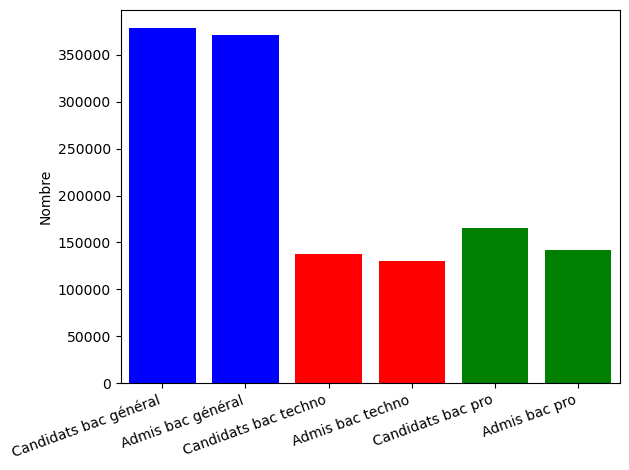

In [51]:
df[["Nombre d'élèves présents au Bac_GNLE","Taux de réussite bruts_GNLE","Nombre d'élèves présents au Bac_Somme Techno","Taux de réussite bruts_Taux brut techno","Nombre d'élèves présents au Bac_TOTAL_Pro","Taux de réussite bruts_TOTAL_Pro"]] 
nbg = df["Nombre d'élèves présents au Bac_GNLE"].sum()
nbgr = np.sum(df["Nombre d'élèves présents au Bac_GNLE"]*df["Taux de réussite bruts_GNLE"])/100
nbt = df["Nombre d'élèves présents au Bac_Somme Techno"].sum()
nbtr = np.sum(df["Nombre d'élèves présents au Bac_Somme Techno"]*df["Taux de réussite bruts_Taux brut techno"])/100
nbp = df["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum()
nbpr = np.sum(df["Nombre d'élèves présents au Bac_TOTAL_Pro"]*df["Taux de réussite bruts_TOTAL_Pro"])/100
plt.bar(["Nombre candidats au baccalauréat général", "Nombre d'élèves ayant réussi le bac général", "Nombre d'élèves présents à un baccalauréat technologique", "Nombre d'élèves ayant réussi un baccalauréat technologique", "Nombre d'élèves présents au bac professionnel", "Nombre d'élèves ayant réussi un baccalauréat professionnel"],[nbg, nbgr, nbt, nbtr, nbp, nbpr], color =['Blue', 'blue', 'red','red','green','green'])
ax = sns.countplot(x=["Candidats bac général", "Admis bac général", "Candidats bac techno", "Admis bac techno", "Candidats bac pro", "Admis bac pro"], data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
plt.tight_layout()
plt.ylabel('Nombre')
plt.show()

__Comentaires du graphique au dessus__

### B - Une première approche des inégalités régionales

Afin d'appronfondir les remarques faites précédemment, nous allons maintenant étudier la répartition des taux de réussite et des revenus entre les différentes académies françaises.

Pour ce faire, nous faisons des diagrammes en barre. Commençons par le taux de réussite par académie selon la filière du baccalauréat. 

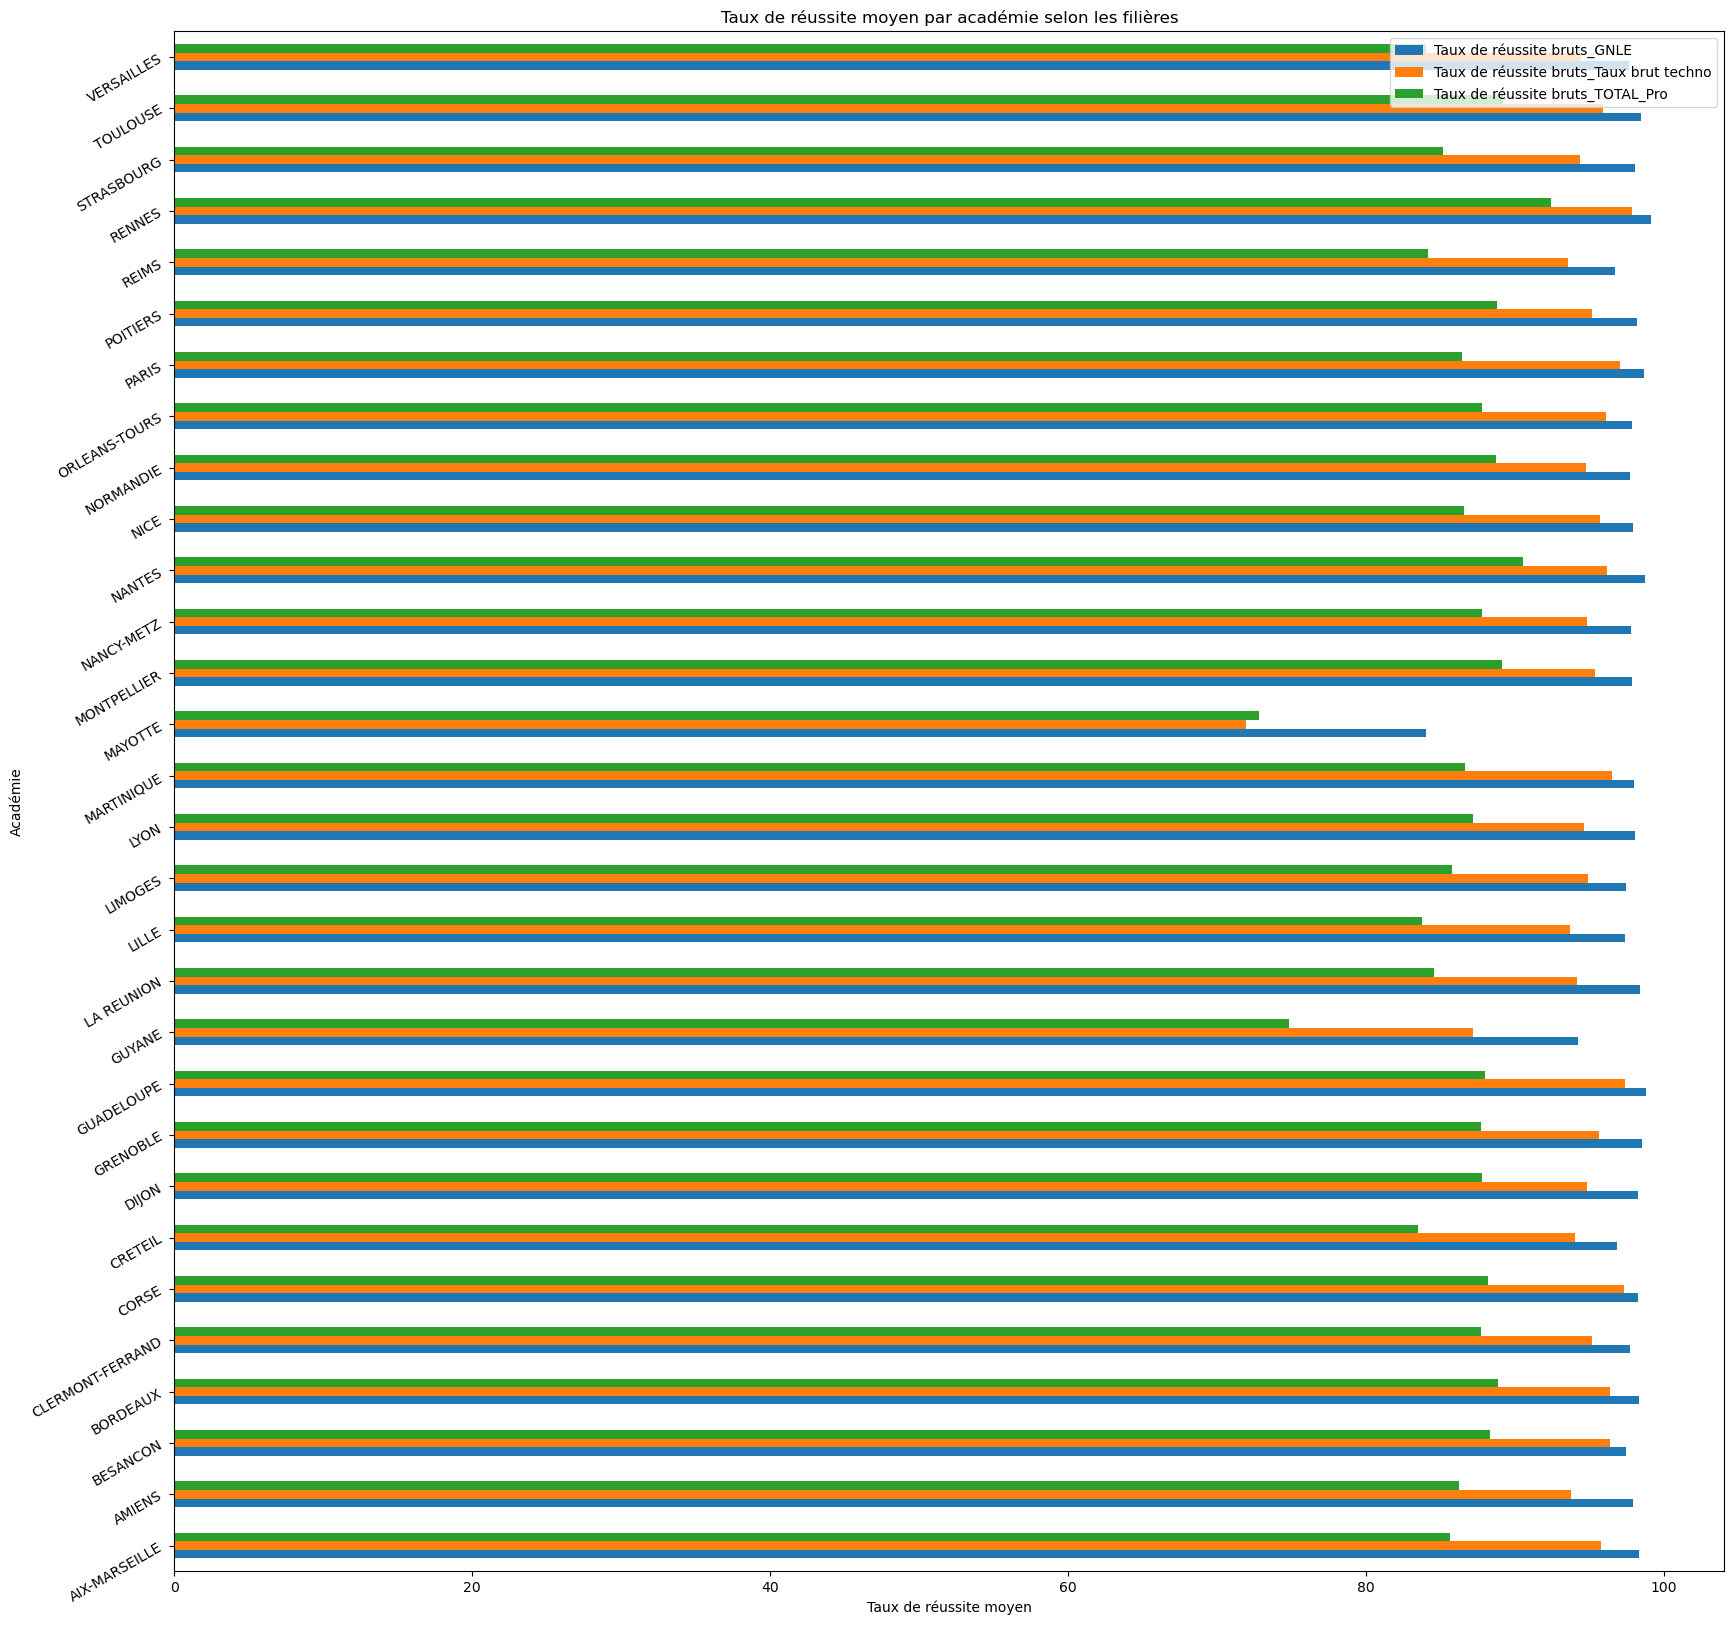

In [104]:
df_barres = df.groupby ("Informations établissement_Académie").agg({"Taux de réussite bruts_GNLE":"mean", "Taux de réussite bruts_Taux brut techno":"mean", "Taux de réussite bruts_TOTAL_Pro":"mean"})
df_barres

df_barres.plot(kind = "barh", rot = 30, figsize = [20,20], title = "Taux de réussite moyen par académie selon les filières", xlabel = "Taux de réussite moyen", ylabel = "Académie")
plt.show()

Tout d'abord, nous observons, comme précédemment, que les taux de réussite pour le bac général sont plus élevés que pour le bac technologique, eux mêmes plus élevés que pour le bac professionnel.

De plus, nous remarquons que les taux de réussite sont sensiblement moins élevés dans les outre-mer, notamment en Guyane et à Mayotte. C'est donc handiccapant pour notre projet de ne pas avoir aux données sur les revenus de ces territoires. 

Des inégalités géographiques apparaissent aussi au sein de la métropole. Nous pouvons remarquer que les taux de réussite sont plus faibles à Créteil qu'à Versailles, or on pourra sans doute prouver que le revenu médian est très différent entre ces deux académies.

Au-delà de cela, nous pouvons constater que les taux de réussite restent très stables entre académie donc il sera peut-être difficile de trouver une corrélation avec le revenu médian.

Représentons à présent la répartition des revenus médians selon les académies.

<AxesSubplot: title={'center': 'Moyenne du revenu médian des ménages de chaque commune par académie'}, xlabel='Moyenne des revenus médians', ylabel='Académie'>

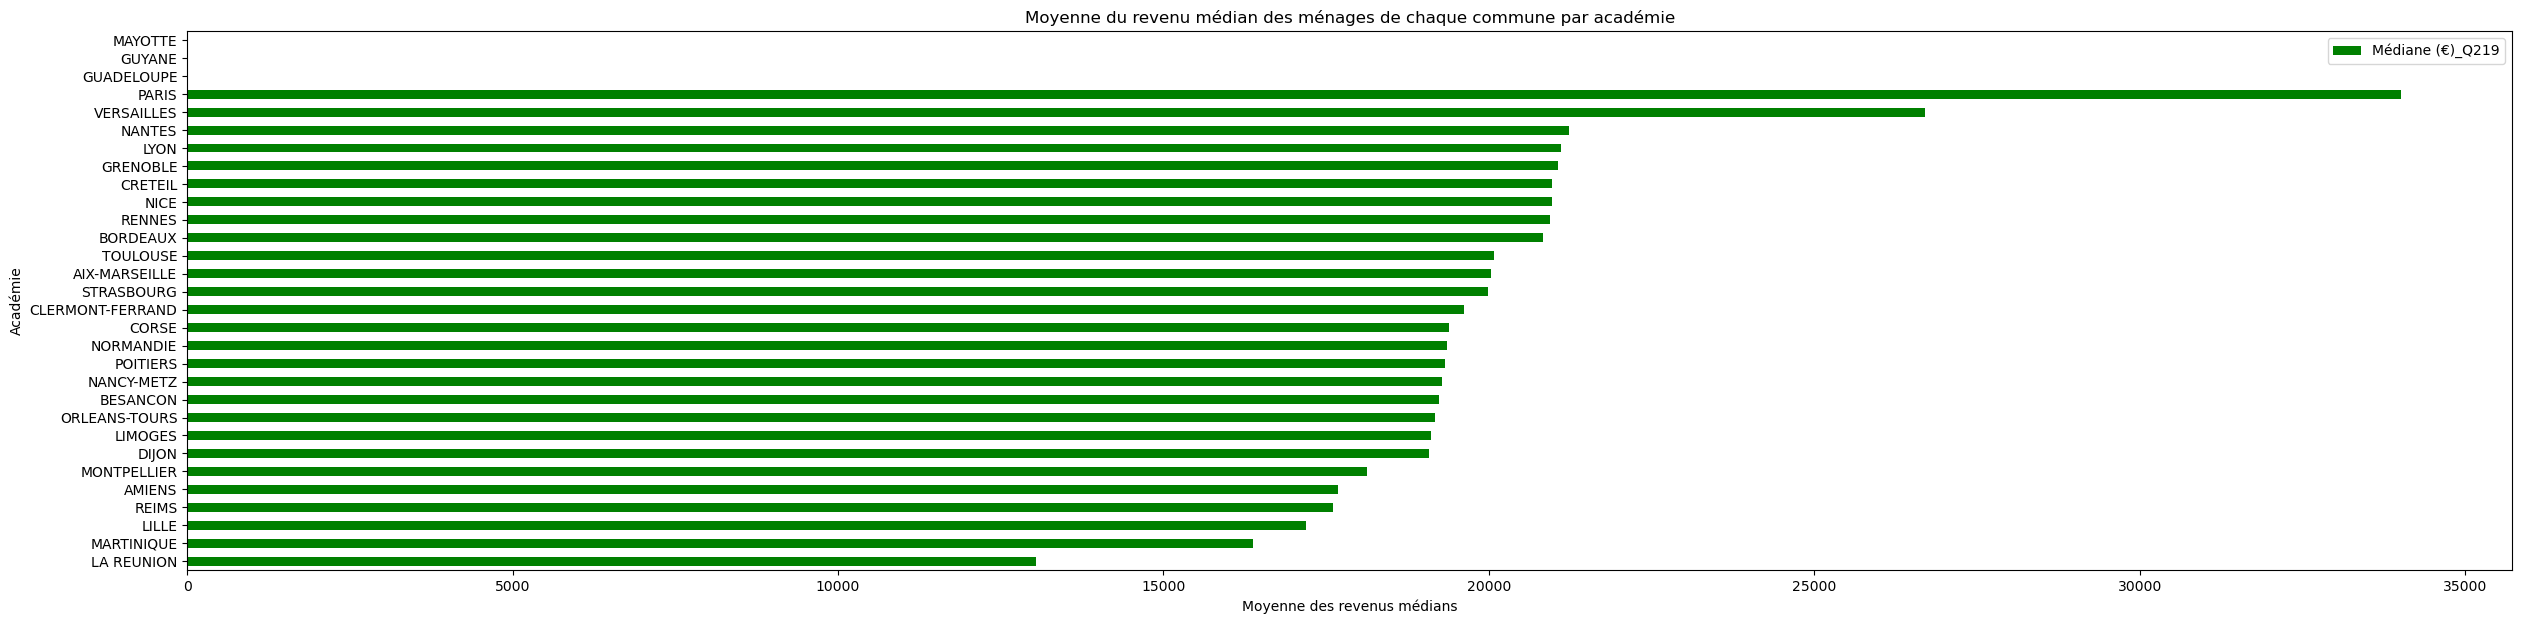

In [106]:
df2 = df.groupby ("Informations établissement_Académie").agg({"Médiane (€)_Q219":"mean"})
p2 = df2.sort_values ("Médiane (€)_Q219").plot (kind="barh", figsize = (30,7), color='green', title = "Moyenne du revenu médian des ménages de chaque commune par académie", xlabel = "Moyenne des revenus médians", ylabel = "Académie")
p2

Ce diagramme nous permet d'identifier les académies les plus riches et les académies les plus pauvres. En tête, nous retrouvons Paris et Versailles et en queue de classement, nous retrouvons les deux outre-mer pour lesquelles nous avons des données (la Réunion et la Martinique).

### C - Une approche plus fine par les déciles

Nous allons chercher à comparer par déciles la répartition des choix de filières ainsi que les taux de réussite aux bacs. 

In [84]:
df3 = df.loc[:,"Taux de réussite bruts_GNLE"]
df3.index[df.isnull().any(axis=1)]

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395],
           dtype='int64', length=4396)

In [85]:
#Préparation de bases de données pour travailler par déciles
q1 = df_SDM['Médiane (€)_Q219'].quantile(0.1)
q2 = df_SDM['Médiane (€)_Q219'].quantile(0.2)
q3 = df_SDM['Médiane (€)_Q219'].quantile(0.3)
q4 = df_SDM['Médiane (€)_Q219'].quantile(0.4)
q5 = df_SDM['Médiane (€)_Q219'].quantile(0.5)
q6 = df_SDM['Médiane (€)_Q219'].quantile(0.6)
q7 = df_SDM['Médiane (€)_Q219'].quantile(0.7)
q8 = df_SDM['Médiane (€)_Q219'].quantile(0.8)
q9 = df_SDM['Médiane (€)_Q219'].quantile(0.9)

df1 = df_SDM[df_SDM['Médiane (€)_Q219']<q1] #Premier décile
df2 = df_SDM[df_SDM['Médiane (€)_Q219']>=q1] 
df2 = df2[df2['Médiane (€)_Q219']<q2] #Deuxième décile
df3 = df_SDM[df_SDM['Médiane (€)_Q219']>=q2] 
df3 = df3[df3['Médiane (€)_Q219']<q3]
df4 = df_SDM[df_SDM['Médiane (€)_Q219']>=q3] 
df4 = df4[df4['Médiane (€)_Q219']<q4]
df5 = df_SDM[df_SDM['Médiane (€)_Q219']>=q4] 
df5 = df5[df5['Médiane (€)_Q219']<q5]
df6 = df_SDM[df_SDM['Médiane (€)_Q219']>=q5] 
df6 = df6[df6['Médiane (€)_Q219']<q6]
df7 = df_SDM[df_SDM['Médiane (€)_Q219']>=q6] 
df7 = df7[df7['Médiane (€)_Q219']<q7]
df8 = df_SDM[df_SDM['Médiane (€)_Q219']>=q7] 
df8 = df8[df8['Médiane (€)_Q219']<q8]
df9 = df_SDM[df_SDM['Médiane (€)_Q219']>=q8] 
df9 = df9[df9['Médiane (€)_Q219']<q9]
df10 = df_SDM[df_SDM['Médiane (€)_Q219']>=q9]

df10.columns

Index(['Identifiant_de_l_etablissement', 'Informations établissement_Académie',
       'Informations établissement_Département',
       'Informations établissement_Etablissement',
       'Informations établissement_Ville', 'Code_commune',
       'Informations établissement_Secteur',
       'Nombre d'élèves présents au Bac_GNLE', 'Taux de réussite bruts_GNLE',
       'Valeur ajoutée du taux de réussite_GNLE',
       'Nombre d'élèves présents au Bac_Somme Techno',
       'Taux de réussite bruts_Taux brut techno',
       'Valeur ajoutée du taux de réussite_Valeur ajoutée techno',
       'Nombre d'élèves présents au Bac_TOTAL_LGT',
       'Taux de réussite bruts_TOTAL_LGT',
       'Valeur ajoutée du taux de réussite_TOTAL_LGT',
       'Nombre d'élèves présents au Bac_TOTAL_Pro',
       'Taux de réussite bruts_TOTAL_Pro',
       'Valeur ajoutée du taux de réussite_TOTAL_Pro',
       'Nbre de ménages fiscaux_NBMEN19',
       'Nbre de personnes dans les ménages fiscaux_NBPERS19',
       'Nbre

In [116]:
#Calcul des taux de candidatures et des taux de réussites pondérés par décile

listedf = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
taux_gen = []
taux_tech = []
taux_pro = []
taux_reussite_total =[]
taux_rgen = []
taux_rtech = []
taux_rpro = []

for elem in listedf:
    #Effectifs totaux par filières + total
    nbg = elem["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum()
    nbt = elem["Nombre d'élèves présents au Bac_Somme Techno"].sum()
    nbp = elem["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum()
    nb = nbp + nbg + nbt
    #Calcul tes taux de candidatures 
    tcg = nbg/nb
    tct = nbt/nb
    tcp = nbp/nb
    #Taux de réussites par filières + total
    trg = (elem["Taux de réussite bruts_GNLE"] * elem["Nombre d'élèves présents au Bac_TOTAL_LGT"]).sum()/nbg
    trt = (elem["Taux de réussite bruts_Taux brut techno"] * elem["Nombre d'élèves présents au Bac_Somme Techno"]).sum()/nbt
    trp = (elem["Taux de réussite bruts_TOTAL_Pro"] * elem["Nombre d'élèves présents au Bac_TOTAL_Pro"]).sum()/nbp
    tr = ((elem["Taux de réussite bruts_TOTAL_Pro"] * elem["Nombre d'élèves présents au Bac_TOTAL_Pro"]).sum()+(elem["Taux de réussite bruts_Taux brut techno"] * elem["Nombre d'élèves présents au Bac_Somme Techno"]).sum()+(elem["Taux de réussite bruts_GNLE"] * elem["Nombre d'élèves présents au Bac_TOTAL_LGT"]).sum())/nb
    #On stocke les éléments dans des listes 
    taux_gen.append(tcg)
    taux_tech.append(tct)
    taux_pro.append(tcp)
    taux_rgen.append(trg)
    taux_rtech.append(trt)
    taux_rpro.append(trp)
    taux_reussite_total.append(tr)

#resultats = [taux_gen, taux_tech, taux_pro, taux_rgen, taux_rtech, taux_rpro, taux_reussite_total]
    

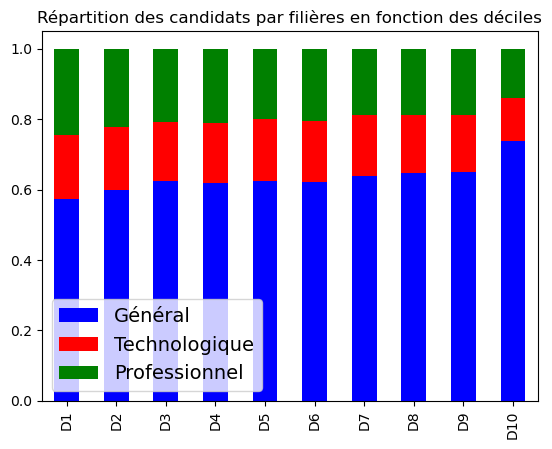

In [140]:
#On crée alors un graphique

dfbar = pd.DataFrame(dict(Général=taux_gen, Technologique=taux_tech, Professionnel=taux_pro))
dfbar = dfbar.rename(index={0:'D1',1:'D2',2:'D3',3:'D4',4:'D5',5:'D6',6:'D7',7:'D8',8:'D9',9:'D10'})
ax = dfbar.plot.bar(stacked=True, color=['blue', 'red','green'])
plt.title("Répartition des candidats par filières en fonction des déciles")
h,l = ax.get_legend_handles_labels()
ax.legend(h[:3],["Général", "Technologique", "Professionnel"], loc=3, fontsize=14)
plt.show()


On s'aperçoit que la part de candidats dans la filière générale augmente au fur et à mesure entre les déciles, surtout entre le neuvième et le dernier décile. La part de la filière technologique suit la trajectoire inverse. Dans les neufs premiers déciles, la part de potentiels pacheliers technologiques reste stable et se réduit dans le dernier décile. 

Le revenu semble sont avoir une influence sur le choix de la filière. Plus on est dans un décile élevé, plus on a de chance de suivre une filière valorisée socialement.

On va désormais s'intéresser au taux de réussite au bac en fonction des filières et des déciles. 

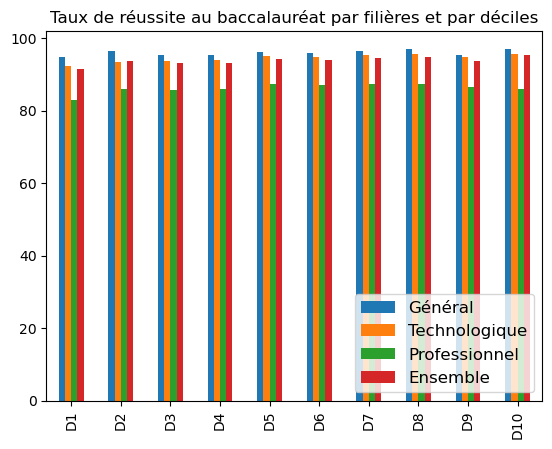

In [155]:
dfbar2 = pd.DataFrame(dict(Général=taux_rgen, Technologique=taux_rtech, Professionnel = taux_rpro, Ensemble=taux_reussite_total))
dfbar2 = dfbar2.rename(index={0:'D1',1:'D2',2:'D3',3:'D4',4:'D5',5:'D6',6:'D7',7:'D8',8:'D9',9:'D10'})
ax2 = dfbar2.plot.bar()
plt.title("Taux de réussite au baccalauréat par filières et par déciles")
h,l = ax2.get_legend_handles_labels()
ax2.legend(h[:4],["Général", "Technologique", "Professionnel", "Ensemble"], loc=4, fontsize=12)
plt.show()


En revanche, en terme de réussite, on ne voit pas de différences flagrantes. Plusieurs explications sont possibles :
- Le revenu n'influence pas la réussite au baccalauréat. (Cette explication demeure étonnante au regard des résultats montrés par la sociologie de l'éducation). 
- Etant donné que les élèves sont déjà triés dans les filières associées à leur milieu social, ils réussissent à avoir leur baccalauréat.
- On est face à une limite de notre hypothèse initiale : associer le niveau de revenu des élèves à celui du revenu médian de la commune dans laquelle se trouve leur établissement scolaire. 

## III - La modélisation

Bien que nos statistiques descriptives semblent montrer qu'il n'existe pas réellement de corrélation entre le taux de réussite au bac d'un lycée et le revenu médian de la commune dans laquelle il se trouve, nous allons tester cette hypothèses à l'aide d'une régression linéaire.
Nous réalisons donc un nuage de points avec le revenu en abscisses et le taux de réussite en ordonnées puis nous ajoutons une droite de régression. Afin de quantifier la pertinence de la régression, nous calculons également le R².

Commençons par réaliser une régression pour le baccalauréat général. 

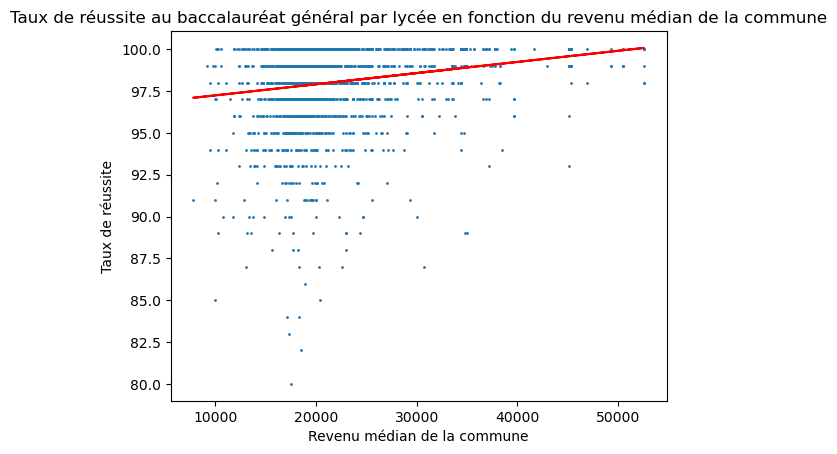

R² =  -11.87056397076805


In [109]:
#Régression pour le général
df_reg = df[[ "Médiane (€)_Q219", "Taux de réussite bruts_GNLE"]]
df_reg = df_reg.dropna(axis = 0, how = "any")
df_reg

x = np.array(df_reg[["Médiane (€)_Q219"]])
y = np.array(df_reg[["Taux de réussite bruts_GNLE"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.title ("Taux de réussite au baccalauréat général par lycée en fonction du revenu médian de la commune")
plt.xlabel ("Revenu médian de la commune")
plt.ylabel ("Taux de réussite")
plt.show()

r2 = r2_score (x, y)
print("R² = ", r2)

D'un premier abord, le nuage de points semble suggérer qu'il peut exister une corrélation car les valeurs extrêmes du taux de réussite au bac se concentrent vers les valeurs les plus faibles du revenu médian. Pour autant, il existe de très nombreux points à 100% de réussite au bac général quel que soit le revenu médian de la commune. Ainsi, bien que la droite de régression soit croissante, le R² indique qu'on ne peut pas en déduire une corrélation entre le revenu médian de la commune et le taux de réussite au bac général.

Nous réalisons cette régression également pour le bac technologique et professionnel mais nous obtenons des résultats similaires. 

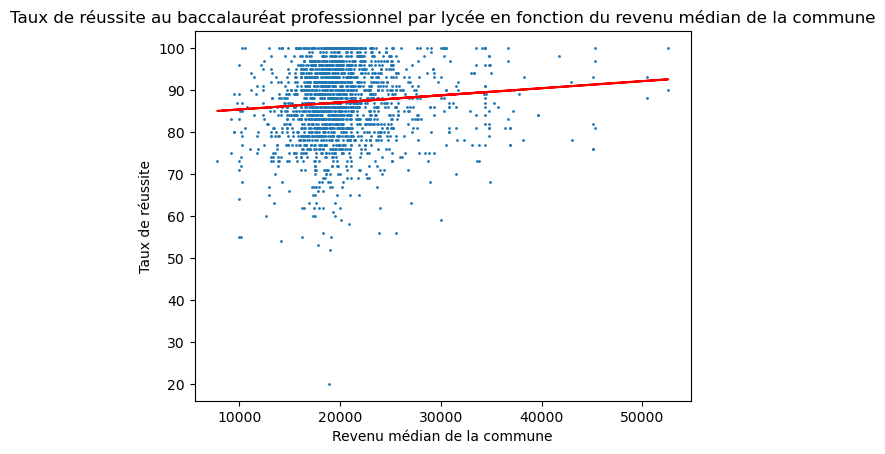

R² =  -16.794820452121847


In [111]:
#Régression pour le professionnel
df_reg_pro = df[[ "Médiane (€)_Q219", "Taux de réussite bruts_TOTAL_Pro"]]
df_reg_pro = df_reg_pro.dropna(axis = 0, how = "any")
df_reg_pro

x = np.array(df_reg_pro[["Médiane (€)_Q219"]])
y = np.array(df_reg_pro[["Taux de réussite bruts_TOTAL_Pro"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.title ("Taux de réussite au baccalauréat professionnel par lycée en fonction du revenu médian de la commune")
plt.xlabel ("Revenu médian de la commune")
plt.ylabel ("Taux de réussite")
plt.show()

r2 = r2_score (x, y)
print("R² = ", r2)

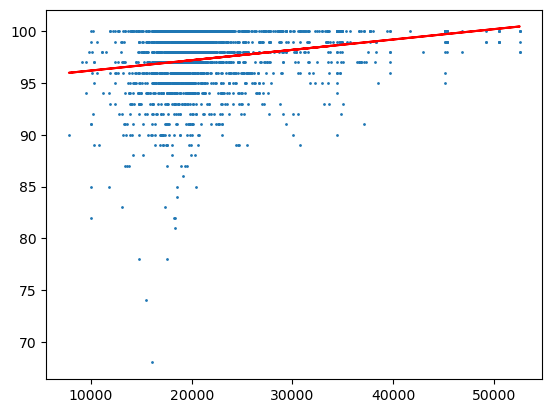

R² =  -11.99260398846476


In [74]:
#Régression pour le technologique
df_reg_techno = df[[ "Médiane (€)_Q219", "Taux de réussite bruts_Taux brut techno"]]
df_reg_techno = df_reg_techno.dropna(axis = 0, how = "any")
df_reg_techno

x = np.array(df_reg_techno[["Médiane (€)_Q219"]])
y = np.array(df_reg_techno[["Taux de réussite bruts_Taux brut techno"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.title ("Taux de réussite au baccalauréat technologique par lycée en fonction du revenu médian de la commune")
plt.xlabel ("Revenu médian de la commune")
plt.ylabel ("Taux de réussite")
plt.show()

r2 = r2_score (x, y)
print("R² = ", r2)

In [ ]:
#Hauts revenus
df4 = df.loc[df["Informations établissement_Académie"] == "VERSAILLES"]
df4

x = df4.loc[:,"Médiane (€)_Q219"]
y = df4.loc[:,"Taux de réussite bruts_GNLE"]
plt.scatter(x,y, s=10)
plt.show()

In [ ]:
#Bas revenus
df5 = df.loc[df["Informations établissement_Académie"] == "LILLE"]
df5

x = df5.loc[:,"Médiane (€)_Q219"]
y = df5.loc[:,"Taux de réussite bruts_GNLE"]
plt.scatter(x,y, s=10)
plt.show()

In [ ]:
#Hauts taux de réussite
df6 = df.loc[df["Informations établissement_Académie"] == "RENNES"]
df6

x = df6.loc[:,"Médiane (€)_Q219"]
y = df6.loc[:,"Taux de réussite bruts_GNLE"]
plt.scatter(x,y, s=10)
plt.show()

In [ ]:
#Bas taux de réussite
df7 = df.loc[df["Informations établissement_Académie"] == "REIMS"]
df7

x = df7.loc[:,"Médiane (€)_Q219"]
y = df7.loc[:,"Taux de réussite bruts_GNLE"]
plt.scatter(x,y, s=10)
plt.show()

# Code brut Rose #

In [38]:
df2 = df.copy()
df2["test"] = df["Nbre d'unités de consommation dans les ménages fiscaux_NBUC19"]*df["Médiane (€)_Q219"]
df3= df2.groupby("Informations établissement_Académie")["test"].sum()
test = df3/df.groupby("Informations établissement_Académie")["Nbre d'unités de consommation dans les ménages fiscaux_NBUC19"].sum()

df4 = df.copy()
df4["test"] = df["Nbre d'unités de consommation dans les ménages fiscaux_NBUC19"]*df["Médiane (€)_Q219"]
df5 = df4.groupby("Informations établissement_Département")["test"].sum()

test_2 = df5/df.groupby("Informations établissement_Département")["Nbre d'unités de consommation dans les ménages fiscaux_NBUC19"].sum()

type(test_2)

pandas.core.series.Series

In [46]:
type(df.groupby("Informations établissement_Département")["Nombre d'élèves présents au Bac_GNLE"].sum() / (df.groupby("Informations établissement_Département")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() + df.groupby("Informations établissement_Département")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum()))
x = df.groupby("Informations établissement_Département")["Nombre d'élèves présents au Bac_GNLE"].sum() / (df.groupby("Informations établissement_Département")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() + df.groupby("Informations établissement_Département")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum())

frame = {"Part général dans présence au bac": x, "test_2": test_2}
df_reg = pd.DataFrame(frame)
df_reg = df_reg.dropna(axis = 0, how = "any")
df_reg


,Part général dans présence au bac,test_2
Informations établissement_Département,,
AIN,0.600159,19498.912801
AISNE,0.480512,15981.094484
ALLIER,0.513134,18146.687243
ALPES DE HTE PROVENCE,0.534496,19410.686958
ALPES MARITIMES,0.596552,20249.850345
...,...,...
VENDEE,0.577062,21497.125926
VIENNE,0.557786,18303.894547
VOSGES,0.504971,18015.448191


R² =  -195800902970.7857


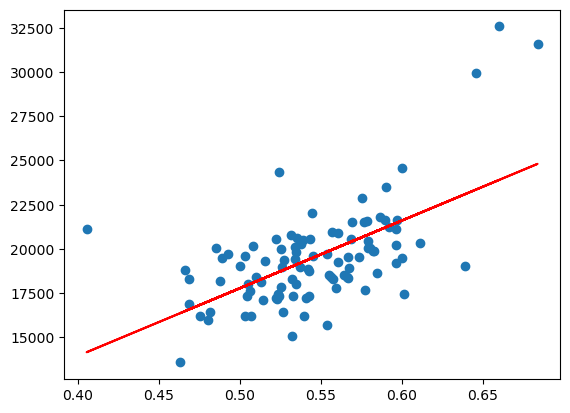

In [48]:
x = np.array(df_reg[["Part général dans présence au bac"]])
y = np.array(df_reg[["test_2"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)

plt.scatter(x, y)
plt.plot(x, y_predicted, color='r')

r2 = r2_score (x, y)
print("R² = ", r2)

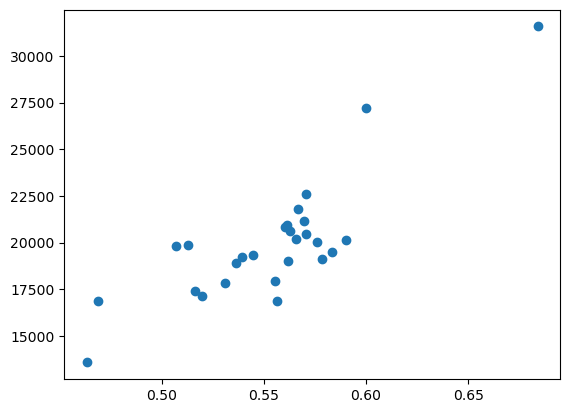

In [26]:
x = df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_GNLE"].sum() / (df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() + df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum())
y = test
plt.scatter(x.values, y.values)

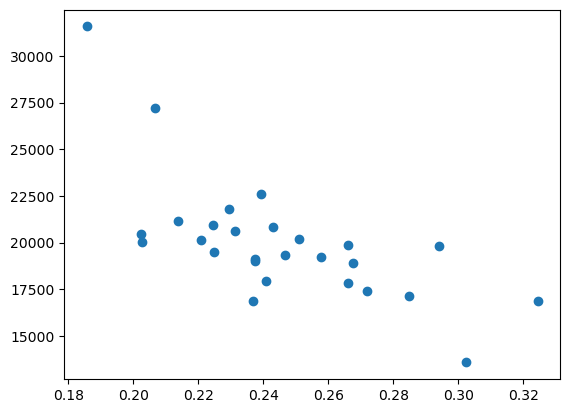

In [27]:
x = df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() / (df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() + df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum())
y = test
plt.scatter(x.values, y.values)

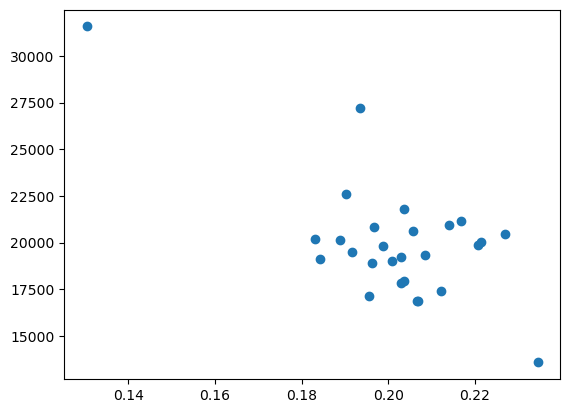

In [28]:
x = df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_Somme Techno"].sum() / (df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() + df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum())
y = test
plt.scatter(x.values, y.values)

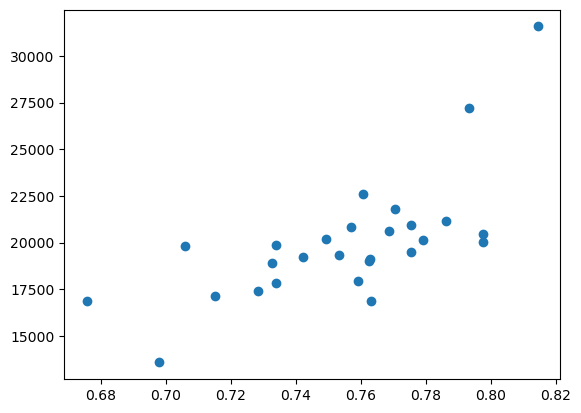

In [29]:
x = df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum() / (df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() + df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum())
y = test
plt.scatter(x.values, y.values)

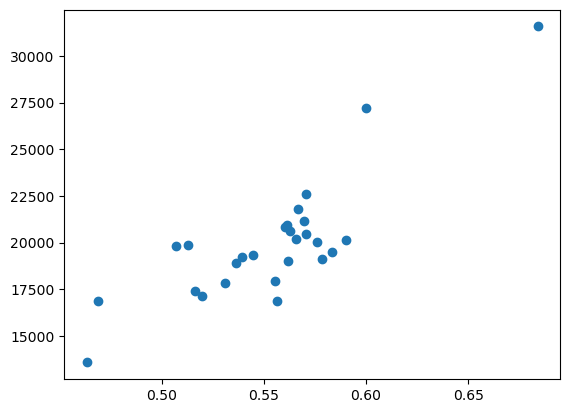

In [30]:
a = df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_Somme Techno"].sum() 
b = df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() 
c = df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum()
d = df.groupby("Informations établissement_Académie")["Nombre d'élèves présents au Bac_GNLE"].sum()
x = d/(b+c)
y = test
plt.scatter(x.values, y.values)